In [1]:
import pandas as pd
import numpy as np

# Title of the wkbk

## State data

Read the data

In [2]:
df_state = pd.read_csv('../data/USA/State/state_data.csv')
df_state.head(4)

,N,State_Name,Code,GDP_PC,gini,cost_living,hdi
0,1,Alabama,AL,45219,0.4847,89.87,4.04
1,2,Alaska,AK,73205,0.4081,122.88,5.06
2,3,Arizona,AZ,48055,0.4713,97.66,4.89
3,4,Arkansas,AR,42454,0.4719,89.17,3.91


We scale our observations: 

In [3]:
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
scaler = StandardScaler()

In [4]:
states_data = pd.DataFrame(scaler.fit_transform(df_state[['GDP_PC','gini','cost_living','hdi']]), 
                             columns=['GDP_PC','gini','cost_living','hdi'])
states_data = pd.concat([df_state[['Code']], states_data], axis=1)

In [5]:
states_data.head()

,Code,GDP_PC,gini,cost_living,hdi
0,AL,-0.725897,0.798117,-0.779450,-1.502166
1,AK,0.522078,-2.500225,0.769120,0.164700
2,AZ,-0.599432,0.221122,-0.414004,-0.113111
3,AR,-0.849196,0.246958,-0.812289,-1.714610
4,CA,0.566671,1.022025,1.972417,0.720322


I want a function that given a state s and a number n and a df X, returns n similar states:

In [6]:
from scipy.spatial import distance

def GaussianKernel(v1, v2, sigma):
    l2norm = distance.euclidean(v1[1:], v2[1:])
    return np.exp(-l2norm**2/(2.*sigma**2))

def sim_states(s, n, X):    
    x = X[X.Code == s]
    X2 = X[X.Code != s].copy()
    X2['dist'] = X2.apply(GaussianKernel, args=(x.iloc[0], 1), axis=1)
    X2 = X2.sort_values(by=['dist'], ascending=False)   
    return list(X2.Code[:n])
    

In [7]:
sim_states('NY', 4, states_data)

['CA', 'CT', 'MA', 'NJ']

## State Model

Read the data

In [8]:
X = pd.read_csv('../data/USA/LC/X_train.csv')
y = pd.read_csv('../data/USA/LC/y_train.csv')
y = y.loan_condition  #as series

AttributeError: 'DataFrame' object has no attribute 'loan_condition'

### Model that uses no context

For each state use data from possible states (the bigest ones) and find neighbors among them. Use them (and not the ones from that specific state to predict.

The model is called knnEstimator1:

In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score
from sklearn import base
from transformers import ColumnSelectTransformer, ScalerEncoderTransformer

class knnEstimator2(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, n=10, n_states=3, states_data=None):
        #n=n. neighbors, p_states=n. states used in find neigh
        self.dKnn_ = {}
        self.n = n
        self.n_states = n_states 
        self.states_data = states_data

    
    def fit(self, X, y):  
        # fit dictionary        
        states = X.addr_state.unique()        
        
        for i,s in enumerate(states): 
            #we remove the state from where the sample is for prediction, we sample from remaining             
                      
            poss_states2 = sim_states(s, self.n_states, self.states_data)
            
            #we subset our data 
            X2 = X[X['addr_state'].isin(poss_states2)]     
            y2 = y[y.index.isin(X2.index)]
            
            #we fit our dictionary
            cst2 = ScalerEncoderTransformer()    
            X3 = cst2.fit_transform(X2)  #X3 has indices reset
            #nn does not use adress state
            del X3['addr_state']
            #we save our fitted model, our ys and our scaler in the dictionary for that state
            self.dKnn_[s] = [NearestNeighbors(n_neighbors=self.n).fit(X3), y2.reset_index(drop=True), cst2]  
            
            #we print our progress
            print('fit progress: {}%'.format(round(((i+1)/len(states))*100,2)))   
            
            
    def pred_state(self, X, s):        
        if s in self.dKnn_:
            #we have fitted using this state            
            X2 = self.dKnn_[s][2].transform(X)
            del X2['addr_state']
            distance, indices = self.dKnn_[s][0].kneighbors(X2)
            y = self.dKnn_[s][1] 
            p = np.array([sum(y[i])/self.n for i in indices])                       
            return p 
        else:
            p = np.empty(X.shape[0])
            p[:] = np.NaN
            return p    
        
    
    def predict(self, X):
        X = X.sort_values(by=['addr_state'])
        probs = np.array([])
        states = X.addr_state.unique()        
        for i,s in enumerate(states):
            X2 = X[X.addr_state == s]           
            probs = np.append(probs, self.pred_state(X2, s), axis=0)
            #we print our progress
            print('predict progress: {}%'.format(round(((i+1)/len(states))*100,2)))            
        X['y_score'] = probs
        X = X.sort_index()
        return np.array(X.y_score)
    
    
    def score(self, X, y):
        y_scores = self.predict(X)
        return roc_auc_score(y, y_scores)   

ImportError: cannot import name 'ScalerEncoderTransformer'

In [10]:
knnvars = ['annual_inc','emp_length','loan_amnt','home_ownership','term', 'year']

In [11]:
cst = ColumnSelectTransformer(knnvars)
X3 = cst.transform(X)

In [31]:
knnE = knnEstimator2(200, 4, states_data)
knnE.fit(X, y)

fit progress: 1.96%
fit progress: 3.92%
fit progress: 5.88%
fit progress: 7.84%
fit progress: 9.8%
fit progress: 11.76%
fit progress: 13.73%
fit progress: 15.69%
fit progress: 17.65%
fit progress: 19.61%
fit progress: 21.57%
fit progress: 23.53%
fit progress: 25.49%
fit progress: 27.45%
fit progress: 29.41%
fit progress: 31.37%
fit progress: 33.33%
fit progress: 35.29%
fit progress: 37.25%
fit progress: 39.22%
fit progress: 41.18%
fit progress: 43.14%
fit progress: 45.1%
fit progress: 47.06%
fit progress: 49.02%
fit progress: 50.98%
fit progress: 52.94%
fit progress: 54.9%
fit progress: 56.86%
fit progress: 58.82%
fit progress: 60.78%
fit progress: 62.75%
fit progress: 64.71%
fit progress: 66.67%
fit progress: 68.63%
fit progress: 70.59%
fit progress: 72.55%
fit progress: 74.51%
fit progress: 76.47%
fit progress: 78.43%
fit progress: 80.39%
fit progress: 82.35%
fit progress: 84.31%
fit progress: 86.27%
fit progress: 88.24%
fit progress: 90.2%
fit progress: 92.16%
fit progress: 94.12%
f

In [32]:
X2=X[X.addr_state.isin(['ME','NM','KS','LA'])]
y2 = y[y.index.isin(X2.index)]

In [33]:
y_scores = knnE.predict(X2)

predict progress: 25.0%
predict progress: 50.0%
predict progress: 75.0%
predict progress: 100.0%


In [34]:
y_target = np.array(y2)

In [35]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_target, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)

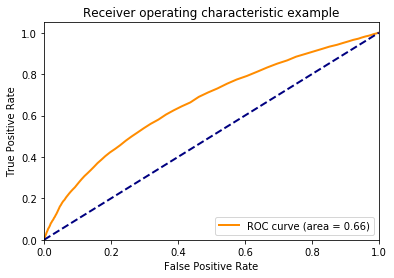

In [36]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()